# Find Tbreak Assuming two linear regression (require at least 5Pts)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
# Ensure best_params_low and best_params_high are initialized
best_params_low_initial = [0, 0]  # Default initial values, could be replaced with actual initial estimates
best_params_high_initial = [0, 0]  # Default initial values, could be replaced with actual initial estimates

# Function to perform the linear regression and find the best Tbreak
def find_best_tbreak(temperatures, log_yields, Tm):
    best_tbreak = None
    best_score = float('inf')
    best_params_low = None
    best_params_high = None

    # Iterate over all possible break points (excluding the first and last points)
    for i in range(2, len(temperatures) - 2):
        print(i)
        # Split the data into two segments
        temp_low = temperatures[:i+1]
        log_ys_low = log_yields[:i+1]
        temp_high = temperatures[i+1:]
        log_ys_high = log_yields[i+1:]

        # Perform linear regression on both segments
        params_low = np.polyfit(temp_low / Tm, log_ys_low, 1)
        params_high = np.polyfit(temp_high / Tm, log_ys_high, 1)

        low_y_fit_score=np.mean(log_ys_low-np.polyval(params_low,temp_low / Tm))
        high_y_fit_score=np.mean(log_ys_high-np.polyval(params_high,temp_high / Tm))

        intercptX=abs((params_high[1]-params_low[1])/(params_high[0]-params_low[0]))
        intercptY=params_high[0]*intercptX+params_high[1]
        print(intercptY,log_ys_low[-1],log_ys_high[0])

        if intercptY<log_ys_low[-1] and intercptY>log_ys_high[0]:
            score=low_y_fit_score**2+high_y_fit_score**2
            print(low_y_fit_score)
            if score < best_score:
                best_score = score
                best_tbreak = intercptX
                best_params_low = params_low
                best_params_high = params_high
        else:
            pass
    return best_tbreak, best_params_low, best_params_high,intercptX,intercptY

# Input data
# temperatures_extended = np.array([300, 673, 873, 973, 1073, 1273,1800])  # Temperatures in Kelvin
# yield_strengths_extended = np.array([1100, 998, 880, 860, 840, 110,1])   # Yield strengths in MPa


temperatures_extended = np.array([400,600,800,1000,1200,1715])  # Temperatures in Kelvin
yield_strengths_extended = np.array([1070,1020, 875, 375, 100,1])   # Yield strengths in MPa
Tm_updated = 1800  # Updated melting temperature in Kelvin

# Convert yield strengths to log scale
log_yield_strengths = np.log(yield_strengths_extended)

# Apply the function to the dataset
best_tbreak, best_params_low, best_params_high, intercptX,intercptY = find_best_tbreak(temperatures_extended, log_yield_strengths, Tm_updated)


plt.figure(figsize=(10, 6))
plt.plot(temperatures_extended / Tm_updated, log_yield_strengths, 'o', label='Log(Data)')
plt.plot([temperatures_extended[0]/Tm_updated,intercptX],[log_yield_strengths[0],intercptY], label='Best Fit Low T', color='red')
plt.plot([intercptX,temperatures_extended[-1]/Tm_updated],[intercptY,log_yield_strengths[-1]], label='Best Fit High T', color='blue')
plt.axvline(intercptX, color='green', linestyle='--', label=f'Best Tbreak = {intercptX:.2f} K')
plt.xlabel('T/Tm')
plt.ylabel('Log(Yield Strength)')
plt.legend()
plt.title('Best Tbreak and Linear Fits for Both Segments')
plt.show()

best_tbreak, best_params_low, best_params_high


# Find Tbreak and Plot using General Optimization 

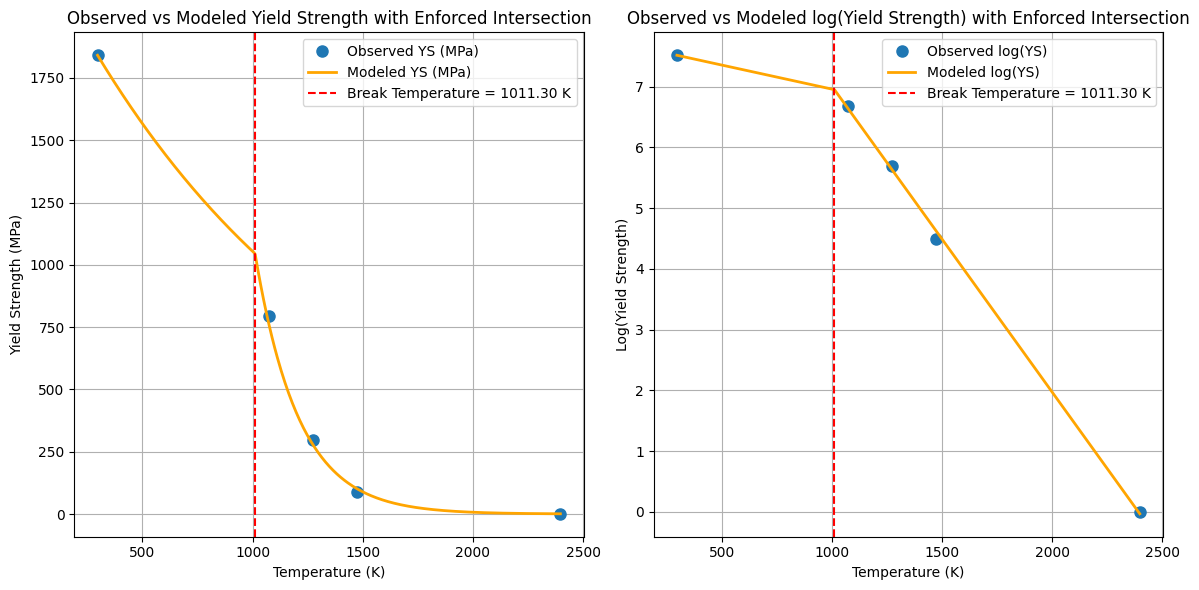

(1011.2959401940077,
 -1.8988688845717443,
 7.7526549252934345,
 -12.07834263931691,
 12.047113128361762)

In [26]:


import numpy as np
from scipy.optimize import differential_evolution
import matplotlib.pyplot as plt

# Provided data: Temperature (K) and corresponding Yield Strength (MPa)
# temperatures = np.array([300, 673, 873, 973, 1073, 1273,1727])
# ys_observed = np.array([1100, 998, 880, 860, 840, 110,1])
temperatures = np.array([23,800,1000,1200,2124.0])
ys_observed = np.array([1841,796,298,89,1])

# temperatures = np.array([400,600,800,1000,1200,1715.0])  # Temperatures in Kelvin
# ys_observed = np.array([1070,1020, 875, 375, 100,1])   # Yield strengths in MPa

# temperatures = np.array([25,900,1000,1100,1200,2197.85])  # Temperatures in Kelvin
# ys_observed = np.array([1835,783,350,270,142,1])   # Yield strengths in MPa

temperatures+=273.15

# Assume a melting temperature Tm (This value should be estimated or provided)
Tm = temperatures[-1]  # Example value in Kelvin for a refractory alloy

# Function to calculate MSE with enforced intersection at Tbreak
def calculate_mse_intercept(params):
    Tbreak, c1, b1, c2 = params
    b2 = b1 + (c1 - c2) * (Tbreak / Tm)  # Enforce intersection at Tbreak
    log_ys_model = np.where(
        temperatures <= Tbreak,
        c1 * (temperatures / Tm) + b1,
        c2 * (temperatures / Tm) + b2
    )
    log_ys_observed = np.log(ys_observed)
    mse = np.mean((log_ys_model - log_ys_observed) ** 2)
    return mse

# Use differential evolution to optimize the parameters with the enforced intersection
paraBound=35
bounds_intercept = [(temperatures.min()*1.2, temperatures.max()*0.8), (-paraBound, 0), (-paraBound, paraBound), (-paraBound, 0)]
result_intercept = differential_evolution(calculate_mse_intercept, bounds_intercept)

# Extract the optimized parameters
Tbreak_opt_intercept, c1_opt_intercept, b1_opt_intercept, c2_opt_intercept = result_intercept.x

# Calculate b2 with the enforced condition
b2_opt_intercept = b1_opt_intercept + (c1_opt_intercept - c2_opt_intercept) * (Tbreak_opt_intercept / Tm)

# Generate a smooth temperature range for plotting
temperature_smooth = np.linspace(temperatures.min(), temperatures.max(), 500)

# Generate the modeled log(YS) using the optimized parameters with enforced intersection
log_ys_model_smooth_intercept = np.where(
    temperature_smooth <= Tbreak_opt_intercept,
    c1_opt_intercept * (temperature_smooth / Tm) + b1_opt_intercept,
    c2_opt_intercept * (temperature_smooth / Tm) + b2_opt_intercept
)

# Plotting the observed vs modeled yield strength with enforced intersection
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(temperatures, ys_observed, 'o', label='Observed YS (MPa)', markersize=8)
plt.plot(temperature_smooth, np.exp(log_ys_model_smooth_intercept), '-', label='Modeled YS (MPa)', linewidth=2, color='orange')
plt.axvline(x=Tbreak_opt_intercept, color='r', linestyle='--', label=f'Break Temperature = {Tbreak_opt_intercept:.2f} K')
plt.title('Observed vs Modeled Yield Strength with Enforced Intersection')
plt.xlabel('Temperature (K)')
plt.ylabel('Yield Strength (MPa)')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(temperatures, np.log(ys_observed), 'o', label='Observed log(YS)', markersize=8)
plt.plot(temperature_smooth, log_ys_model_smooth_intercept, '-', label='Modeled log(YS)', linewidth=2, color='orange')
plt.axvline(x=Tbreak_opt_intercept, color='r', linestyle='--', label=f'Break Temperature = {Tbreak_opt_intercept:.2f} K')
plt.title('Observed vs Modeled log(Yield Strength) with Enforced Intersection')
plt.xlabel('Temperature (K)')
plt.ylabel('Log(Yield Strength)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Output the optimized parameters
Tbreak_opt_intercept, c1_opt_intercept, b1_opt_intercept, c2_opt_intercept, b2_opt_intercept


In [ ]:


import numpy as np
from scipy.optimize import differential_evolution
import matplotlib.pyplot as plt

# Provided data: Temperature (K) and corresponding Yield Strength (MPa)
# temperatures = np.array([300, 673, 873, 973, 1073, 1273,1727])
# ys_observed = np.array([1100, 998, 880, 860, 840, 110,1])

# temperatures = np.array([25,400,600,1447.64])
# ys_observed = np.array([354,260,155,1])

temperatures = np.array([23,800,1000,1200,2124.0])
ys_observed = np.array([1841,796,298,89,1])

# temperatures = np.array([400,600,800,1000,1200,1715.0])  # Temperatures in Kelvin
# ys_observed = np.array([1070,1020, 875, 375, 100,1])   # Yield strengths in MPa

# temperatures = np.array([25,900,1000,1100,1200,2197.85])  # Temperatures in Kelvin
# ys_observed = np.array([1835,783,350,270,142,1])   # Yield strengths in MPa

temperatures+=273.15

# Assume a melting temperature Tm (This value should be estimated or provided)
Tm = temperatures[-1]  # Example value in Kelvin for a refractory alloy

# Function to calculate MSE with enforced intersection at Tbreak
def calculate_mse_intercept(params):
    Tbreak, c1, b1, c2 = params
    b2 = b1 + (c1 - c2) * (Tbreak / Tm)  # Enforce intersection at Tbreak
    log_ys_model = np.where(
        temperatures <= Tbreak,
        c1 * (temperatures / Tm) + b1,
        c2 * (temperatures / Tm) + b2
    )
    log_ys_observed = np.log(ys_observed)
    mse = np.mean((log_ys_model - log_ys_observed) ** 2)
    return mse

# Use differential evolution to optimize the parameters with the enforced intersection
paraBound=40
bounds_intercept = [(temperatures.min(), temperatures.max()), (-paraBound, paraBound), (-paraBound, paraBound), (-paraBound, paraBound)]
result_intercept = differential_evolution(calculate_mse_intercept, bounds_intercept)

# Extract the optimized parameters
Tbreak_opt_intercept, c1_opt_intercept, b1_opt_intercept, c2_opt_intercept = result_intercept.x

# Calculate b2 with the enforced condition
b2_opt_intercept = b1_opt_intercept + (c1_opt_intercept - c2_opt_intercept) * (Tbreak_opt_intercept / Tm)

# Generate a smooth temperature range for plotting
temperature_smooth = np.linspace(temperatures.min(), temperatures.max(), 500)

# Generate the modeled log(YS) using the optimized parameters with enforced intersection
log_ys_model_smooth_intercept = np.where(
    temperature_smooth <= Tbreak_opt_intercept,
    c1_opt_intercept * (temperature_smooth / Tm) + b1_opt_intercept,
    c2_opt_intercept * (temperature_smooth / Tm) + b2_opt_intercept
)

# Plotting the observed vs modeled yield strength with enforced intersection
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(temperatures, ys_observed, 'o', label='Observed YS (MPa)', markersize=8)
plt.plot(temperature_smooth, np.exp(log_ys_model_smooth_intercept), '-', label='Modeled YS (MPa)', linewidth=2, color='orange')
plt.axvline(x=Tbreak_opt_intercept, color='r', linestyle='--', label=f'Break Temperature = {Tbreak_opt_intercept:.2f} K')
plt.title('Observed vs Modeled Yield Strength with Enforced Intersection')
plt.xlabel('Temperature (K)')
plt.ylabel('Yield Strength (MPa)')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(temperatures, np.log(ys_observed), 'o', label='Observed log(YS)', markersize=8)
plt.plot(temperature_smooth, log_ys_model_smooth_intercept, '-', label='Modeled log(YS)', linewidth=2, color='orange')
plt.axvline(x=Tbreak_opt_intercept, color='r', linestyle='--', label=f'Break Temperature = {Tbreak_opt_intercept:.2f} K')
plt.title('Observed vs Modeled log(Yield Strength) with Enforced Intersection')
plt.xlabel('Temperature (K)')
plt.ylabel('Log(Yield Strength)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Output the optimized parameters
Tbreak_opt_intercept, c1_opt_intercept, b1_opt_intercept, c2_opt_intercept, b2_opt_intercept


# Find Tbreak Function based on General Optimization 
## Input Temeprature and Yield strength in np.arrays
## Output Tbreak and according Yield strength 

In [10]:
import numpy as np
import pandas as pd
from scipy.optimize import differential_evolution
import matplotlib.pyplot as plt

# Function to calculate Tbreak and yield strength at Tbreak
def calculate_tbreak_and_ys_at_tbreak(temperatures, ys_observed):
    temperatures = np.array(temperatures)
    ys_observed = np.array(ys_observed)

    # Check and replace 0 yield strength values with 1 to avoid log issues
    ys_observed[ys_observed == 0] = 1

    Tm = temperatures[-1]  # Assuming the melting temperature is the last temperature in the array

    def calculate_mse_intercept(params):
        Tbreak, c1, b1, c2 = params
        b2 = b1 + (c1 - c2) * (Tbreak / Tm)  # Enforce intersection at Tbreak
        log_ys_model = np.where(
            temperatures <= Tbreak,
            c1 * (temperatures / Tm) + b1,
            c2 * (temperatures / Tm) + b2
        )
        log_ys_observed = np.log(ys_observed)
        mse = np.mean((log_ys_model - log_ys_observed) ** 2)
        return mse

    def run_optimization():
        paraBound = 35
        bounds_intercept = [(temperatures.min() * 0.25, temperatures.max() * 0.75), (-paraBound, paraBound), (-paraBound, paraBound), (-paraBound, paraBound)]
        result_intercept = differential_evolution(calculate_mse_intercept, bounds_intercept)
        
        Tbreak_opt_intercept, c1_opt_intercept, b1_opt_intercept, c2_opt_intercept = result_intercept.x
        b2_opt_intercept = b1_opt_intercept + (c1_opt_intercept - c2_opt_intercept) * (Tbreak_opt_intercept / Tm)
        ys_at_tbreak = np.exp(c1_opt_intercept * (Tbreak_opt_intercept / Tm) + b1_opt_intercept)
        
        return Tbreak_opt_intercept, ys_at_tbreak, result_intercept.success
    
    # Run the initial optimization
    Tbreak_opt_intercept, ys_at_tbreak, success = run_optimization()
    
    # Check if the yield at Tbreak is larger than the maximum observed yield
    if ys_at_tbreak > max(ys_observed):
        # Rerun the optimization to double-check
        Tbreak_opt_intercept, ys_at_tbreak, success = run_optimization()
        
        # If still an issue, flag the result
        if ys_at_tbreak > max(ys_observed):
            return Tbreak_opt_intercept, ys_at_tbreak, 'Check'
    
    return Tbreak_opt_intercept, ys_at_tbreak, 'OK'

# Example usage of the function
temperatures = [300, 673, 873, 973, 1073, 1273, 1727]
ys_observed = [1100, 998, 880, 860, 840, 110, 1]
Tbreak, ys_at_tbreak, status = calculate_tbreak_and_ys_at_tbreak(temperatures, ys_observed)
Tbreak, ys_at_tbreak, status


(1077.351841526631, 833.3168125639825, 'OK')

In [23]:
import pandas as pd

data=pd.read_csv(r'C:\Users\Sir\Desktop\HEA Pred\previous data\A physics-based machine-learning approach for modeling the temperature-dependent yield strengths of medium- or high-entropy alloys\TBreak Model\ValidationData\Val_With_Features.csv')

In [11]:
# Process each composition and calculate Tbreak and YS at Tbreak
results = []
grouped = data.groupby('Composition')
for comp_name, group in grouped:
    temperatures = group['TempC'].values + 273.15  # Convert to Kelvin
    ys_observed = group['Yield'].values
    
    Tbreak, ys_at_tbreak, status = calculate_tbreak_and_ys_at_tbreak(temperatures, ys_observed)
    
    results.append({'Composition': comp_name, 'Tbreak': Tbreak, 'YS at Tbreak': ys_at_tbreak, 'Status': status})

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Save the results to a CSV file if needed
results_df.to_csv('Tbreak_results.csv', index=False)

# Display the first few results
print(results_df.head())

                                     Composition      Tbreak  YS at Tbreak  \
0       Al0.1Ti0.191Zr0.191Ta0.134Nb0.191Mo0.191  474.728884   4920.110583   
1           Al0.2Ti0.17Zr0.17Ta0.119Nb0.17Mo0.17  884.654827   1232.384883   
2  Al0.3Ti0.1489Zr0.1489Ta0.1043Nb0.1489Mo0.1489  648.561185   2882.196084   
3         Al0.4Ti0.1278Zr0.1278Ta0.08936Mo0.1277  353.440533   7721.190272   
4  Al0.5Ti0.1064Zr0.1064Ta0.0745Nb0.1064Mo0.1064  319.486636  15593.589913   

  Status  
0  Check  
1     OK  
2  Check  
3  Check  
4  Check  


In [2]:


import numpy as np
from scipy.optimize import differential_evolution
import matplotlib.pyplot as plt

# Provided data: Temperature (K) and corresponding Yield Strength (MPa)
# temperatures = np.array([300, 673, 873, 973, 1073, 1273,1727])
# ys_observed = np.array([1100, 998, 880, 860, 840, 110,1])

# temperatures = np.array([25,400,600,1447.64])
# ys_observed = np.array([354,260,155,1])

# temperatures = np.array([23,800,1000,1200,2124.0])
# ys_observed = np.array([1841,796,298,89,1])

# temperatures = np.array([400,600,800,1000,1200,1715.0])  # Temperatures in Kelvin
# ys_observed = np.array([1070,1020, 875, 375, 100,1])   # Yield strengths in MPa

# temperatures = np.array([25,900,1000,1100,1200,2197.85])  # Temperatures in Kelvin
# ys_observed = np.array([1835,783,350,270,142,1])   # Yield strengths in MPa
    # Function to calculate MSE with enforced intersection at Tbreak


def calculate_tbreak_and_save_plot(temperatures, ys_observed,MeltTemp):
    def calculate_mse_intercept(params):
        Tbreak, c1, b1, c2 = params
        b2 = b1 + (c1 - c2) * (Tbreak / Tm)  # Enforce intersection at Tbreak
        log_ys_model = np.where(
            temperatures <= Tbreak,
            c1 * (temperatures / Tm) + b1,
            c2 * (temperatures / Tm) + b2
        )
        log_ys_observed = np.log(ys_observed)
        mse = np.mean((log_ys_model - log_ys_observed) ** 2)
        return mse
    temperatures = np.array(temperatures)
    ys_observed = np.array(ys_observed)

    if ys_observed[-1]>10:
        temperatures=np.append(temperatures,MeltTemp)
        ys_observed=np.append(ys_observed,1)

    # Check and replace 0 yield strength values with 1 to avoid log issues
    ys_observed[ys_observed <= 0] = 1

    # Assume a melting temperature Tm (This value should be estimated or provided)
    Tm = MeltTemp  # Example value in Kelvin for a refractory alloy

    # Use differential evolution to optimize the parameters with the enforced intersection
    paraBound=35
    bounds_intercept = [(temperatures.min(), temperatures.max()*0.8), (-paraBound, 0), (-paraBound, paraBound), (-paraBound, 0)]
    result_intercept = differential_evolution(calculate_mse_intercept, bounds_intercept)

    # Extract the optimized parameters
    Tbreak_opt_intercept, c1_opt_intercept, b1_opt_intercept, c2_opt_intercept = result_intercept.x

    # Calculate b2 with the enforced condition
    b2_opt_intercept = b1_opt_intercept + (c1_opt_intercept - c2_opt_intercept) * (Tbreak_opt_intercept / Tm)
    ys_at_tbreak = np.exp(c1_opt_intercept * (Tbreak_opt_intercept / Tm) + b1_opt_intercept)
    # Generate a smooth temperature range for plotting
    temperature_smooth = np.linspace(temperatures.min(), temperatures.max(), 500)

    # Generate the modeled log(YS) using the optimized parameters with enforced intersection
    log_ys_model_smooth_intercept = np.where(
        temperature_smooth <= Tbreak_opt_intercept,
        c1_opt_intercept * (temperature_smooth / Tm) + b1_opt_intercept,
        c2_opt_intercept * (temperature_smooth / Tm) + b2_opt_intercept
    )

    # Plotting the observed vs modeled yield strength with enforced intersection
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(temperatures, ys_observed, 'o', label='Observed YS (MPa)', markersize=8)
    plt.plot(temperature_smooth, np.exp(log_ys_model_smooth_intercept), '-', label='Modeled YS (MPa)', linewidth=2, color='orange')
    plt.axvline(x=Tbreak_opt_intercept, color='r', linestyle='--', label=f'Break Temperature = {Tbreak_opt_intercept:.2f} K')
    plt.title('Observed vs Modeled Yield Strength with Enforced Intersection')
    plt.xlabel('Temperature (K)')
    plt.ylabel('Yield Strength (MPa)')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(temperatures, np.log(ys_observed), 'o', label='Observed log(YS)', markersize=8)
    plt.plot(temperature_smooth, log_ys_model_smooth_intercept, '-', label='Modeled log(YS)', linewidth=2, color='orange')
    plt.axvline(x=Tbreak_opt_intercept, color='r', linestyle='--', label=f'Break Temperature = {Tbreak_opt_intercept:.2f} K')
    plt.title('Observed vs Modeled log(Yield Strength) with Enforced Intersection')
    plt.xlabel('Temperature (K)')
    plt.ylabel('Log(Yield Strength)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    
    plt.savefig(f'C:\\Users\\Sir\\Desktop\\HEA Pred\\previous data\\A physics-based machine-learning approach for modeling the temperature-dependent yield strengths of medium- or high-entropy alloys\\TBreak Model\\ValidationData\\Line Fit\\{comp_name}_fitted_plot.png')
    plt.close()
    return Tbreak_opt_intercept, ys_at_tbreak


In [5]:
# Process each composition and calculate Tbreak and YS at Tbreak
import pandas as pd

data=pd.read_csv(r'C:\Users\Sir\Desktop\HEA Pred\previous data\A physics-based machine-learning approach for modeling the temperature-dependent yield strengths of medium- or high-entropy alloys\TBreak Model\ValidationData\Val_With_Features.csv')

results = []
grouped = data.groupby('Composition')
for comp_name, group in grouped:
    temperatures = group['TempC'].values + 273.15  # Convert to Kelvin
    ys_observed = group['Yield'].values
    TM=group['Avg Melting Pt'].values[0]
    Tbreak, ys_at_tbreak = calculate_tbreak_and_save_plot(temperatures, ys_observed,TM)

    results.append({'Composition': comp_name, 'Tbreak': Tbreak, 'YS at Tbreak': ys_at_tbreak})
# Display the first few results
print(pd.DataFrame(results).head())

                                     Composition       Tbreak  YS at Tbreak
0       Al0.1Ti0.191Zr0.191Ta0.134Nb0.191Mo0.191  1235.481550    413.008716
1           Al0.2Ti0.17Zr0.17Ta0.119Nb0.17Mo0.17  1279.962386    429.063723
2  Al0.3Ti0.1489Zr0.1489Ta0.1043Nb0.1489Mo0.1489  1318.669542    415.773394
3         Al0.4Ti0.1278Zr0.1278Ta0.08936Mo0.1277  1382.991375    386.894120
4  Al0.5Ti0.1064Zr0.1064Ta0.0745Nb0.1064Mo0.1064  1380.482142    442.946129


In [5]:
resdf=pd.DataFrame(results)

In [7]:
resdf.to_csv("Val_Tbreak_Yield.csv")

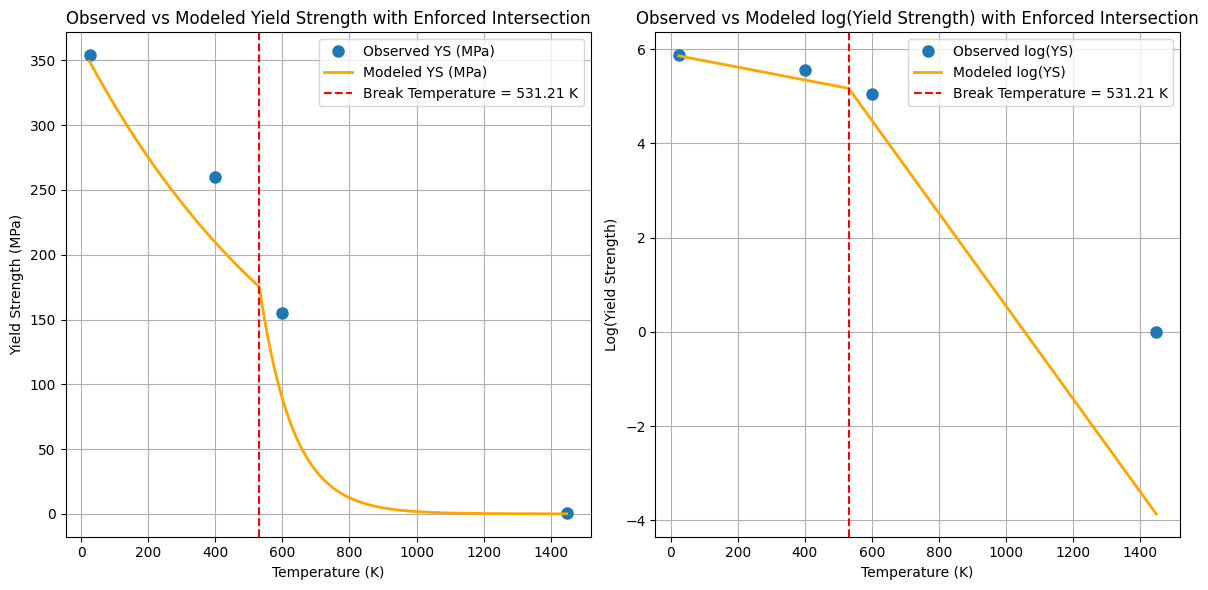

(531.2146317775723, 103.85568820149598, 'OK')

In [79]:
temperatures = np.array([25,400,600,1447.64])
ys_observed = np.array([354,260,155,1])
calculate_tbreak_and_save_plot(temperatures, ys_observed)

C:\Users\Sir\AppData\Local\Temp\ipykernel_19996\4035757975.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Yield Category'] = filtered_df['YS at Tbreak'].apply(lambda x: 'Above 600 MPa' if x > 800 else 'Below 600 MPa')
C:\Users\Sir\AppData\Local\Temp\ipykernel_19996\4035757975.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Local Electronegativity Mismatch'] = pd.to_numeric(filtered_df['Local Electronegativity Mismatch'], errors='coerce')
C:\Users\Sir\AppData\Local\Temp\i

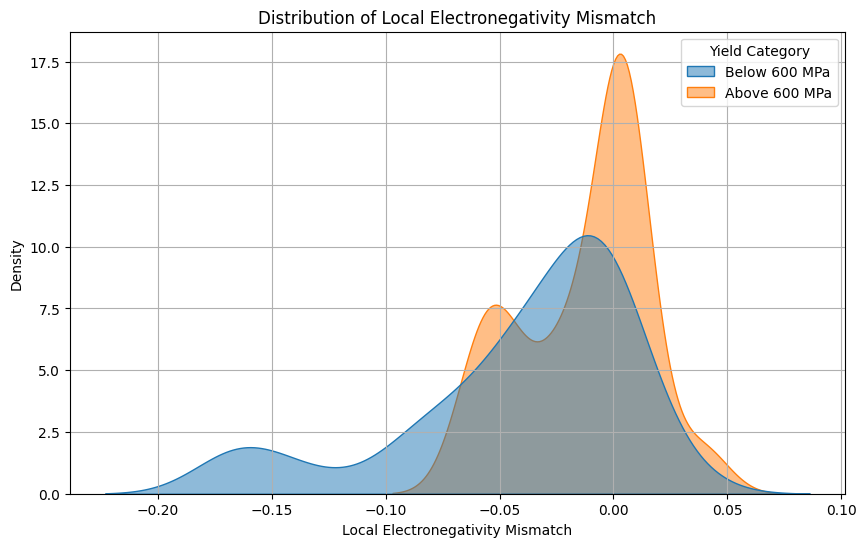

C:\Users\Sir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Sir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Sir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instea

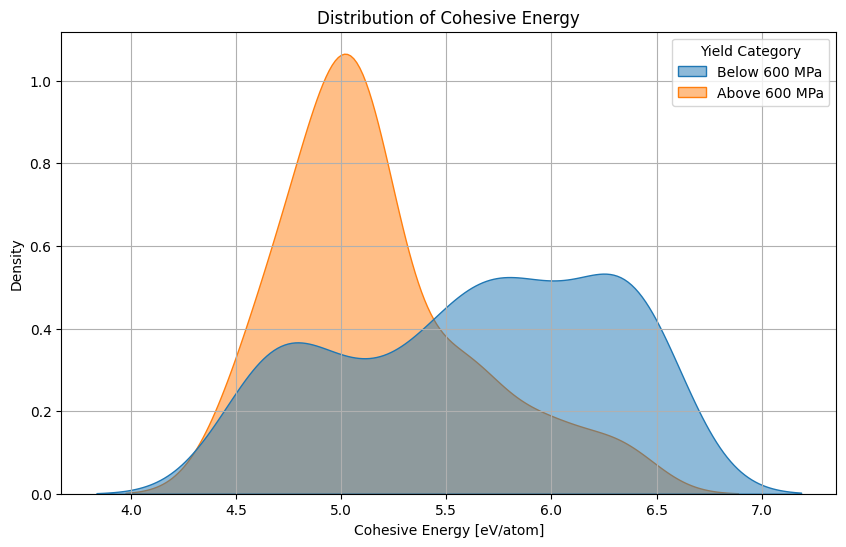

C:\Users\Sir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Sir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Sir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instea

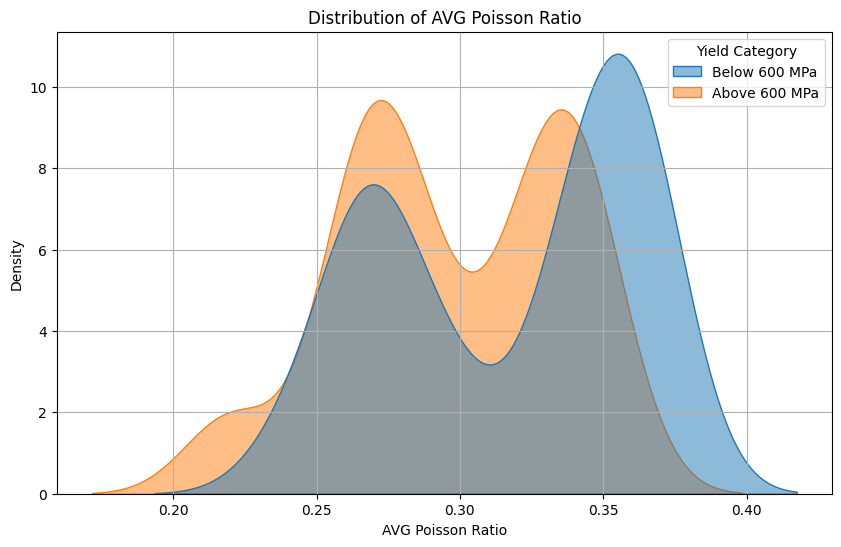

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
file_path = 'Tbreak_None_Removed_Updated.csv'
df = pd.read_csv(file_path)

# Filter the data with Tbreak > 1000K
filtered_df = df[df['Tbreak(K)'] > 1000]

# Create two categories based on Yield strength using "YS at Tbreak"
filtered_df['Yield Category'] = filtered_df['YS at Tbreak'].apply(lambda x: 'Above 600 MPa' if x > 800 else 'Below 600 MPa')

# Ensure all relevant columns are numeric
filtered_df['Local Electronegativity Mismatch'] = pd.to_numeric(filtered_df['Local Electronegativity Mismatch'], errors='coerce')
filtered_df['Cohesive Energy'] = pd.to_numeric(filtered_df['Cohesive Energy'], errors='coerce')
filtered_df['AVG Possion Ratio'] = pd.to_numeric(filtered_df['AVG Possion Ratio'], errors='coerce')

# Drop any rows with NaN values in these columns
filtered_df = filtered_df.dropna(subset=['Local Electronegativity Mismatch', 'Cohesive Energy', 'AVG Possion Ratio'])

# Plot 1: Local Electronegativity Mismatch
plt.figure(figsize=(10, 6))
sns.kdeplot(data=filtered_df, x='Local Electronegativity Mismatch', hue='Yield Category', fill=True, common_norm=False, alpha=0.5)
plt.title('Distribution of Local Electronegativity Mismatch')
plt.xlabel('Local Electronegativity Mismatch')
plt.ylabel('Density')
plt.grid(True)
plt.show()

# Plot 2: Cohesive Energy
plt.figure(figsize=(10, 6))
sns.kdeplot(data=filtered_df, x='Cohesive Energy', hue='Yield Category', fill=True, common_norm=False, alpha=0.5)
plt.title('Distribution of Cohesive Energy')
plt.xlabel('Cohesive Energy [eV/atom]')
plt.ylabel('Density')
plt.grid(True)
plt.show()

# Plot 3: AVG Poisson Ratio
plt.figure(figsize=(10, 6))
sns.kdeplot(data=filtered_df, x='AVG Possion Ratio', hue='Yield Category', fill=True, common_norm=False, alpha=0.5)
plt.title('Distribution of AVG Poisson Ratio')
plt.xlabel('AVG Poisson Ratio')
plt.ylabel('Density')
plt.grid(True)
plt.show()


C:\Users\Sir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\Sir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Sir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` inste

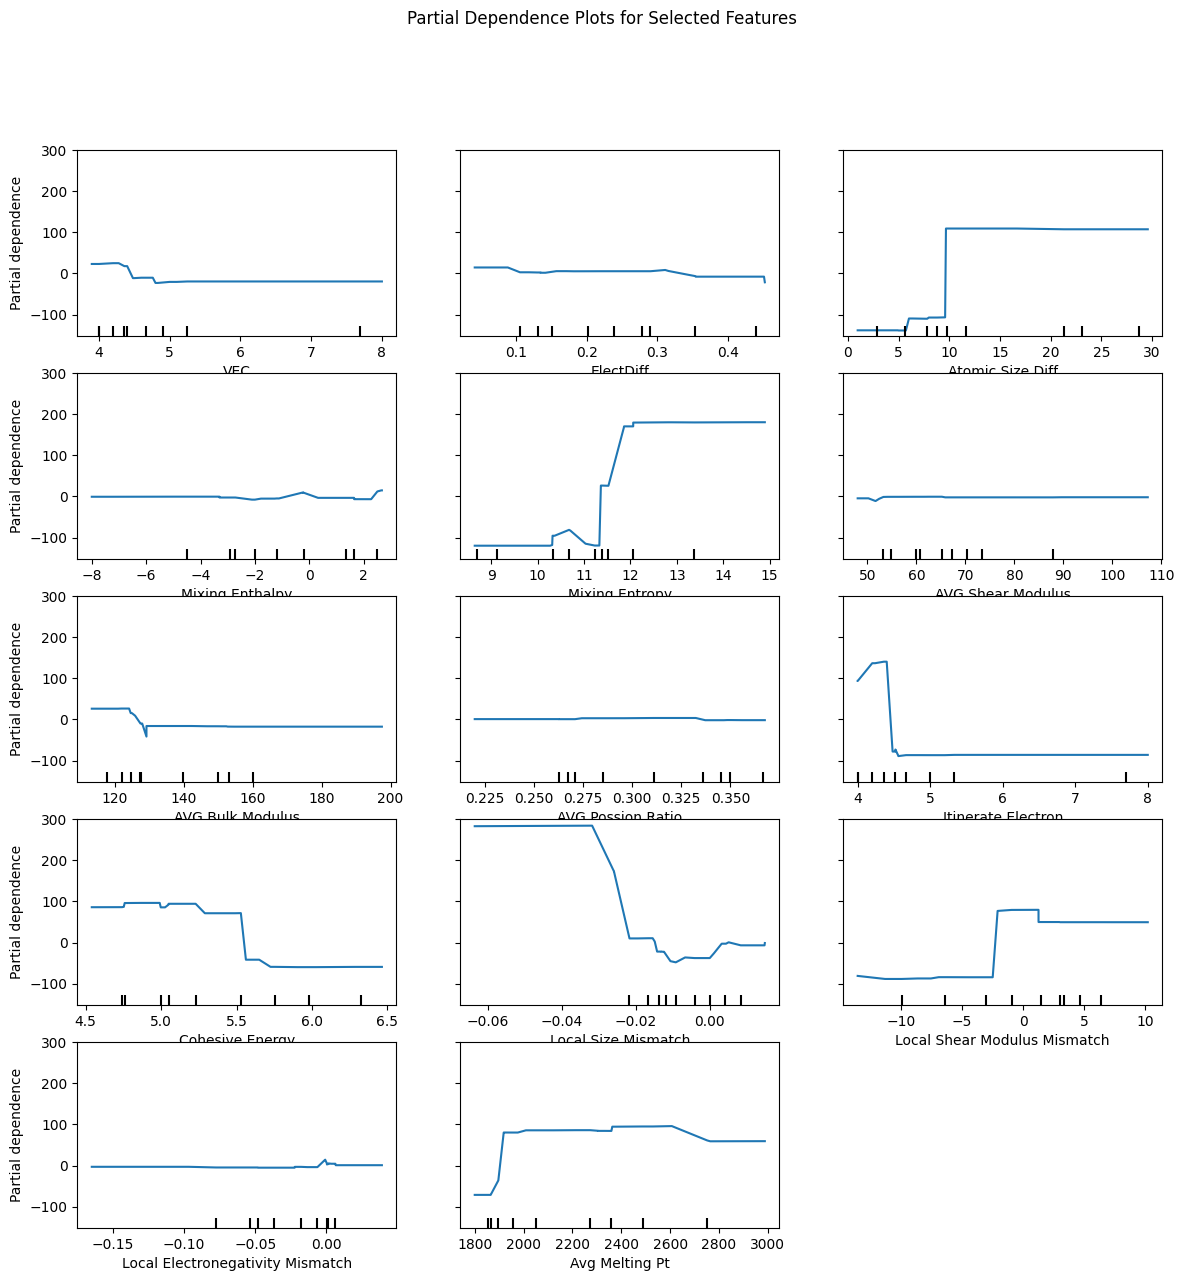

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.inspection import PartialDependenceDisplay
from sklearn.model_selection import train_test_split

# Load the dataset
file_path = 'Tbreak_None_Removed_Updated.csv'
df = pd.read_csv(file_path)

# Filter the data with Tbreak > 1000K
filtered_df = df[df['Tbreak(K)'] > 1000]

# Define the features and target variable
features = [
    'VEC', 'ElectDiff', 'Atomic Size Diff', 'Mixing Enthalpy', 'Mixing Entropy',
    'AVG Shear Modulus', 'AVG Bulk Modulus', 'AVG Possion Ratio', 'Itinerate Electron',
    'Cohesive Energy', 'Local Size Mismatch', 'Local Shear Modulus Mismatch',
    'Local Electronegativity Mismatch', 'Avg Melting Pt'
]
X = filtered_df[features]
y = filtered_df['YS at Tbreak']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a model (e.g., Gradient Boosting Regressor)
model = GradientBoostingRegressor()
model.fit(X_train, y_train)

# Plot Partial Dependence Plots
fig, ax = plt.subplots(figsize=(14, 14))
PartialDependenceDisplay.from_estimator(model, X_train, features, ax=ax)
plt.suptitle('Partial Dependence Plots for Selected Features')
plt.show()


C:\Users\Sir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Sir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


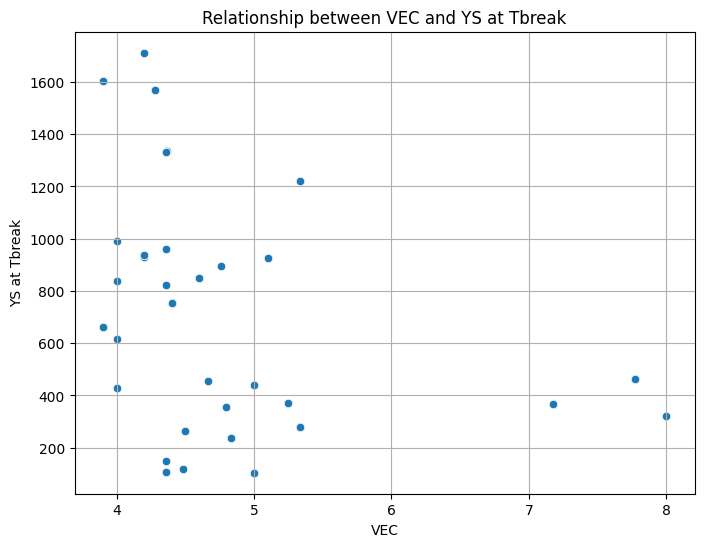

C:\Users\Sir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Sir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


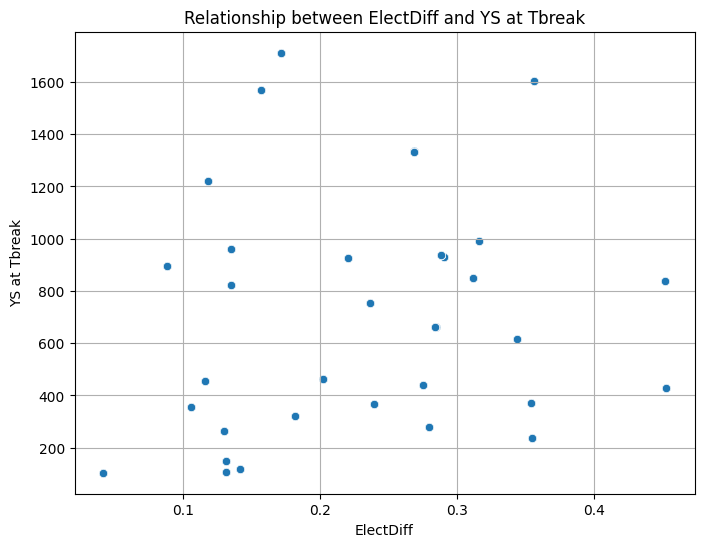

C:\Users\Sir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Sir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


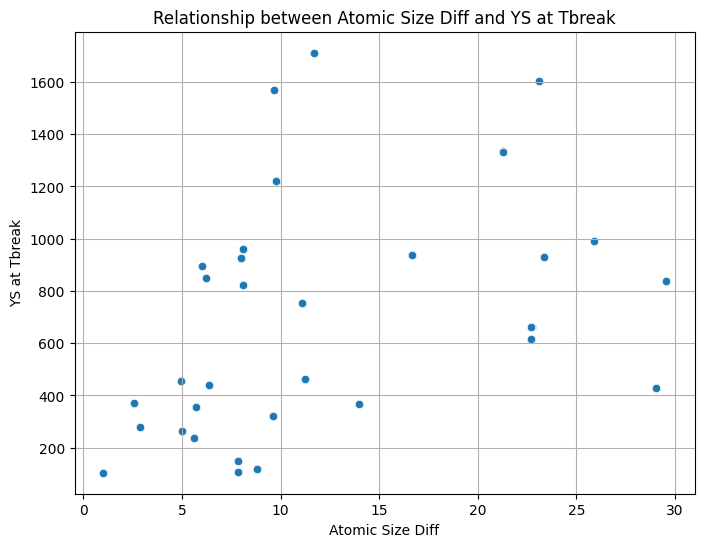

C:\Users\Sir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Sir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


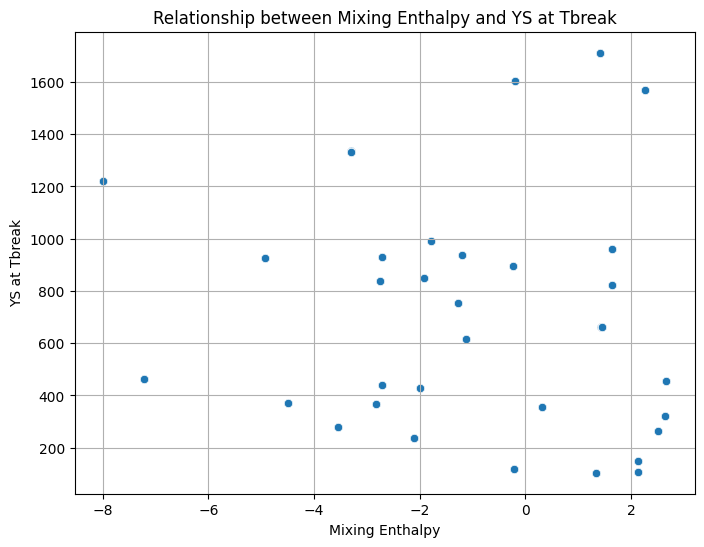

C:\Users\Sir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Sir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


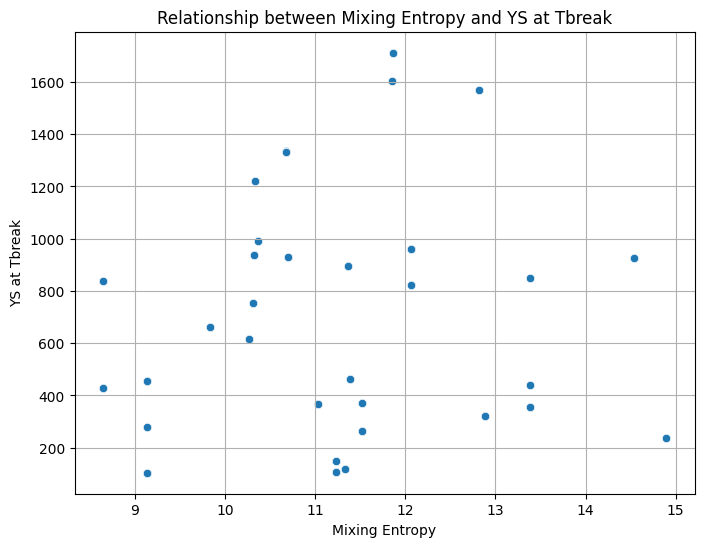

C:\Users\Sir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Sir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


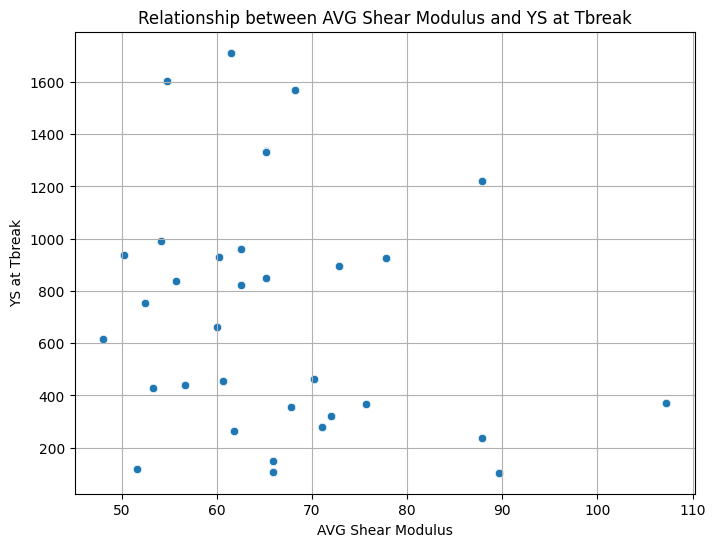

C:\Users\Sir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Sir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


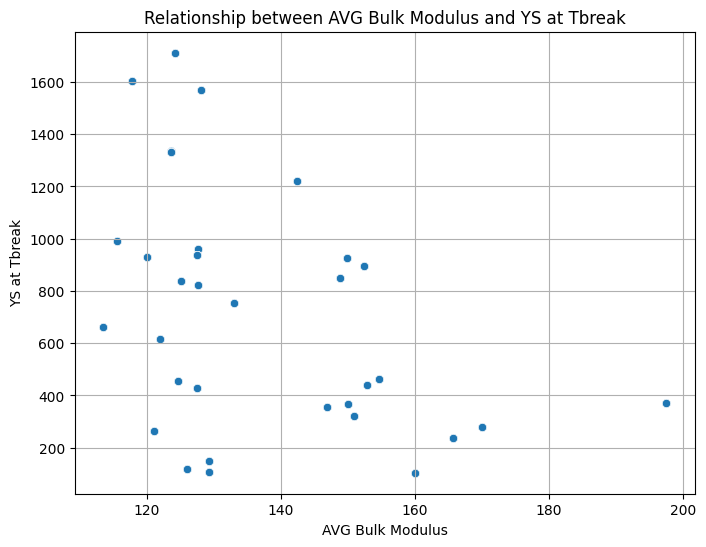

C:\Users\Sir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Sir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


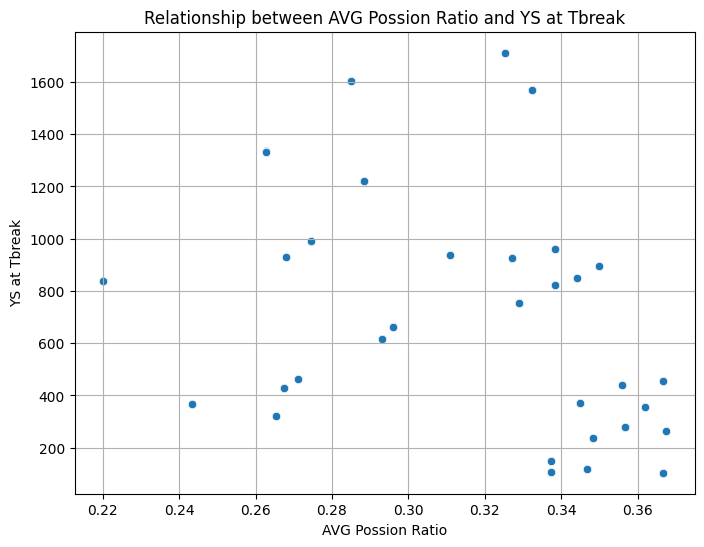

C:\Users\Sir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Sir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


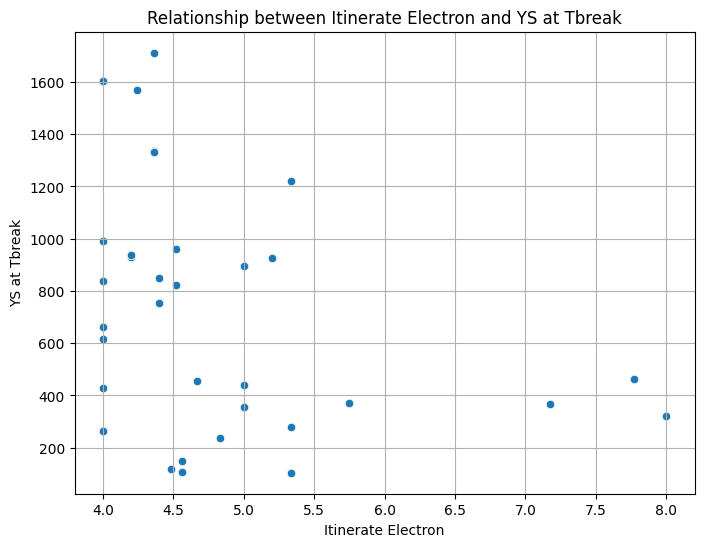

C:\Users\Sir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Sir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


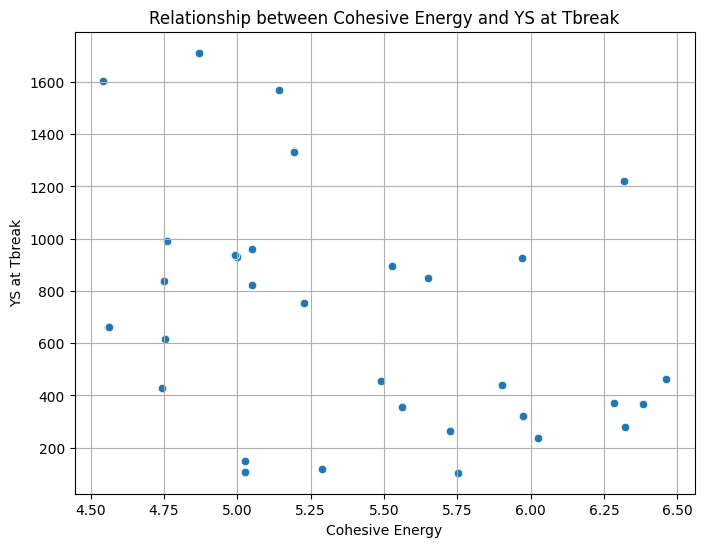

C:\Users\Sir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Sir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


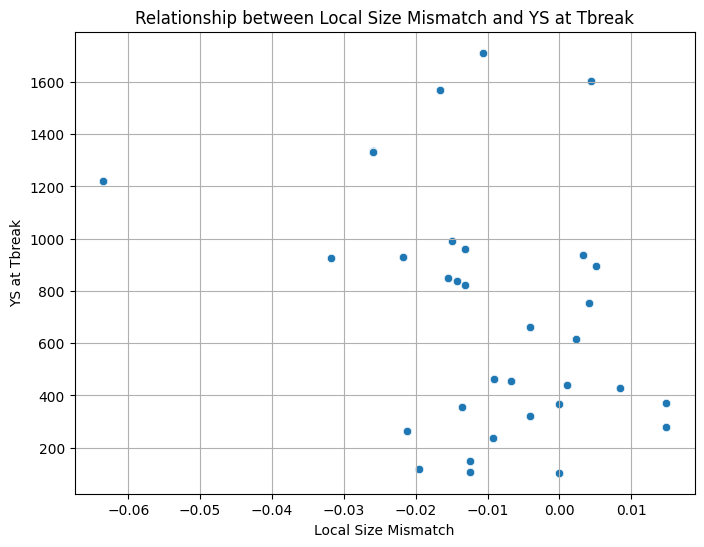

C:\Users\Sir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Sir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


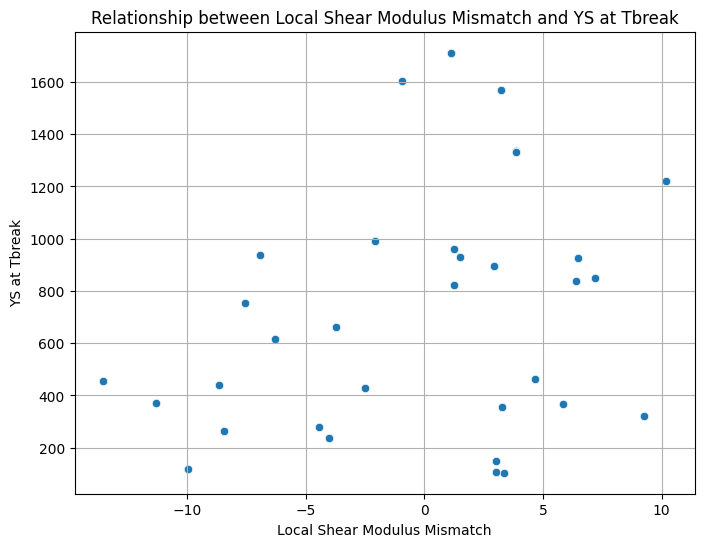

C:\Users\Sir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Sir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


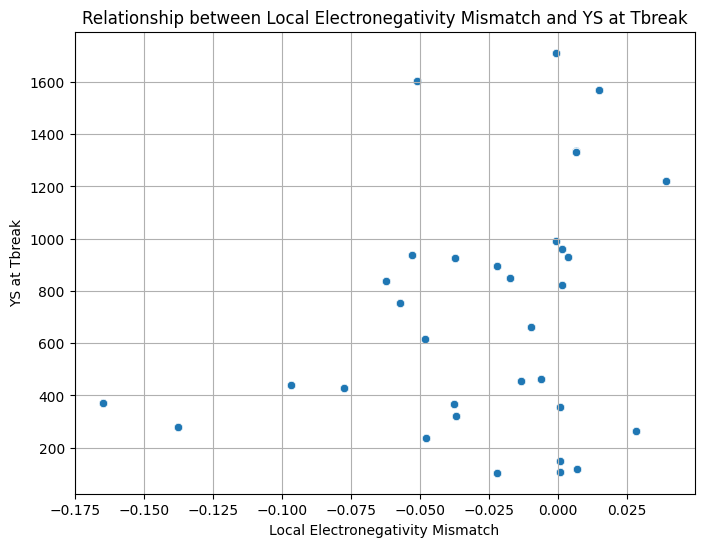

C:\Users\Sir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Sir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


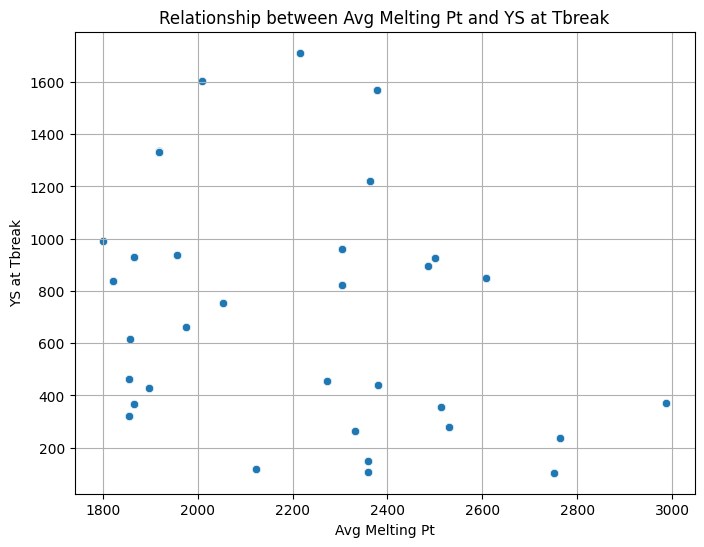

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
file_path = 'Tbreak_None_Removed_Updated.csv'
df = pd.read_csv(file_path)

# Filter the data with Tbreak > 1000K
filtered_df = df[df['Tbreak(K)'] > 1000]

# Define the features
features = [
    'VEC', 'ElectDiff', 'Atomic Size Diff', 'Mixing Enthalpy', 'Mixing Entropy',
    'AVG Shear Modulus', 'AVG Bulk Modulus', 'AVG Possion Ratio', 'Itinerate Electron',
    'Cohesive Energy', 'Local Size Mismatch', 'Local Shear Modulus Mismatch',
    'Local Electronegativity Mismatch', 'Avg Melting Pt'
]

# Plot raw relationships
for feature in features:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=filtered_df, x=feature, y='YS at Tbreak')
    plt.title(f'Relationship between {feature} and YS at Tbreak')
    plt.grid(True)
    plt.show()


C:\Users\Sir\AppData\Local\Temp\ipykernel_19996\3795208505.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['binned_feature'] = pd.cut(filtered_df[feature], bins=20)  # You can adjust the number of bins
C:\Users\Sir\AppData\Local\Temp\ipykernel_19996\3795208505.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_means = filtered_df.groupby('binned_feature')['YS at Tbreak'].mean()


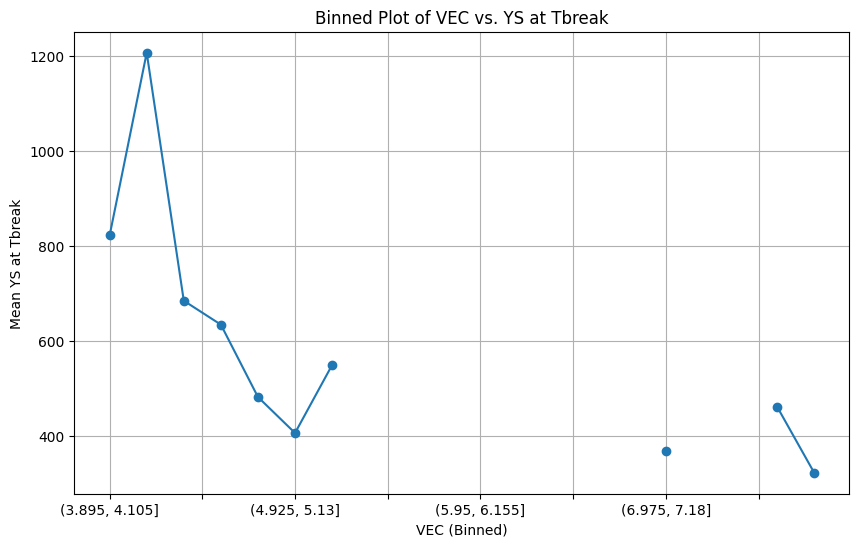

C:\Users\Sir\AppData\Local\Temp\ipykernel_19996\3795208505.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['binned_feature'] = pd.cut(filtered_df[feature], bins=20)  # You can adjust the number of bins
C:\Users\Sir\AppData\Local\Temp\ipykernel_19996\3795208505.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_means = filtered_df.groupby('binned_feature')['YS at Tbreak'].mean()


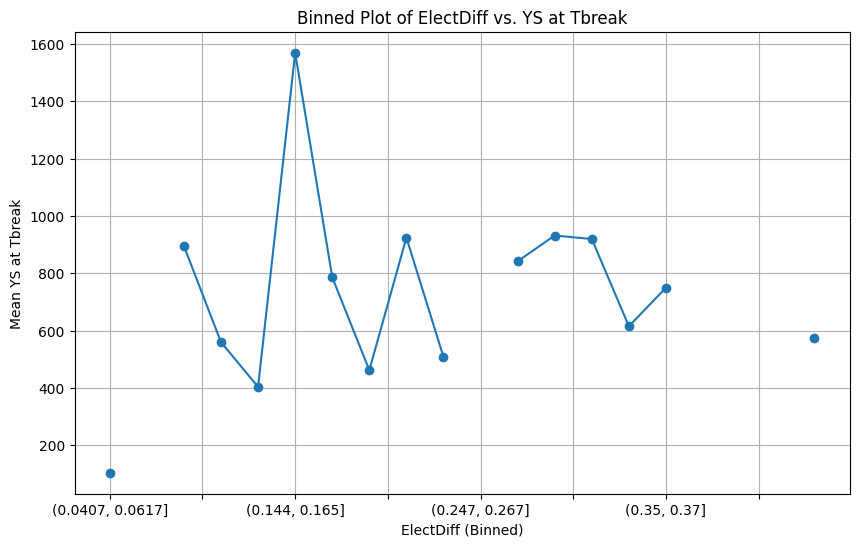

C:\Users\Sir\AppData\Local\Temp\ipykernel_19996\3795208505.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['binned_feature'] = pd.cut(filtered_df[feature], bins=20)  # You can adjust the number of bins
C:\Users\Sir\AppData\Local\Temp\ipykernel_19996\3795208505.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_means = filtered_df.groupby('binned_feature')['YS at Tbreak'].mean()


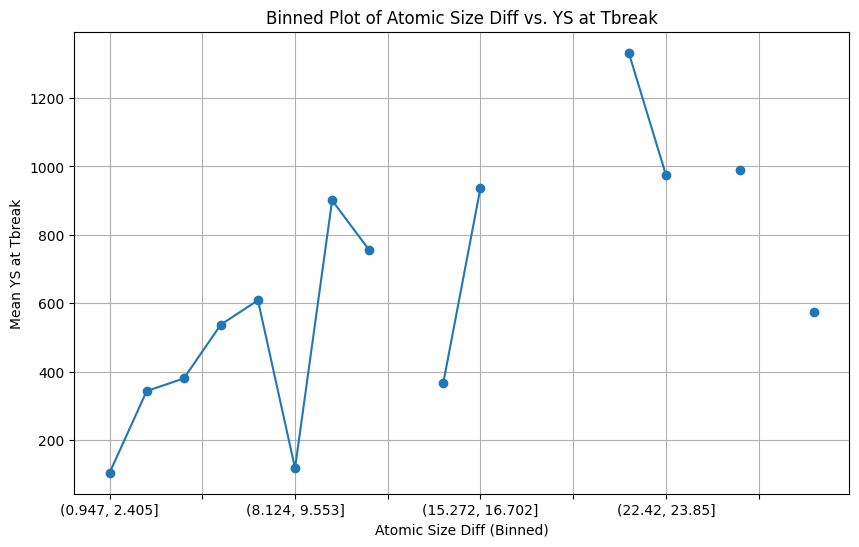

C:\Users\Sir\AppData\Local\Temp\ipykernel_19996\3795208505.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['binned_feature'] = pd.cut(filtered_df[feature], bins=20)  # You can adjust the number of bins
C:\Users\Sir\AppData\Local\Temp\ipykernel_19996\3795208505.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_means = filtered_df.groupby('binned_feature')['YS at Tbreak'].mean()


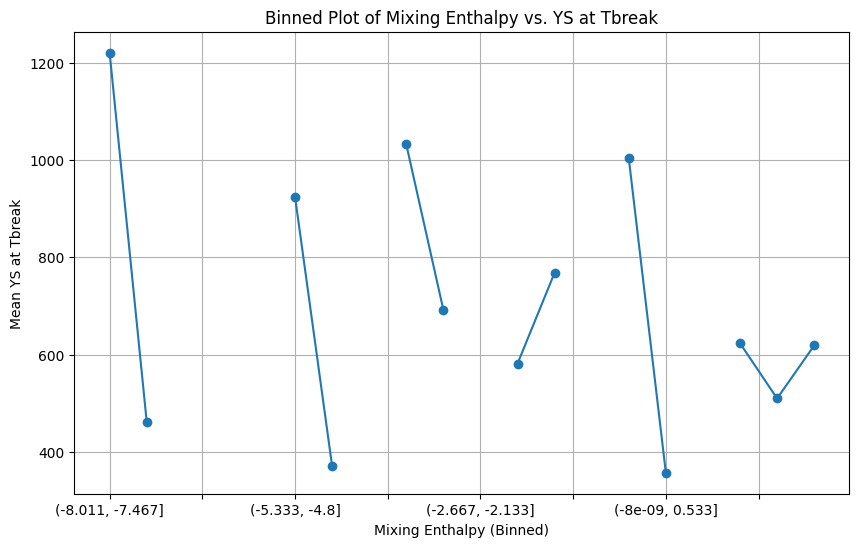

C:\Users\Sir\AppData\Local\Temp\ipykernel_19996\3795208505.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['binned_feature'] = pd.cut(filtered_df[feature], bins=20)  # You can adjust the number of bins
C:\Users\Sir\AppData\Local\Temp\ipykernel_19996\3795208505.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_means = filtered_df.groupby('binned_feature')['YS at Tbreak'].mean()


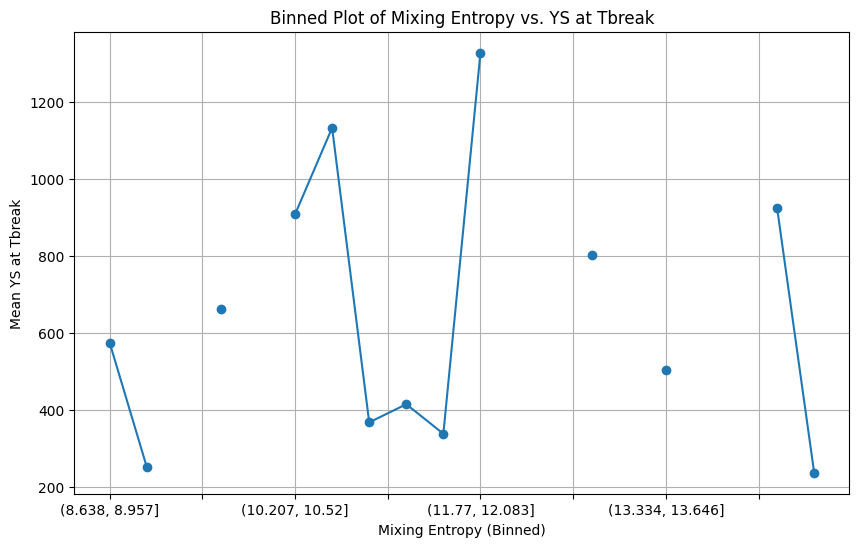

C:\Users\Sir\AppData\Local\Temp\ipykernel_19996\3795208505.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['binned_feature'] = pd.cut(filtered_df[feature], bins=20)  # You can adjust the number of bins
C:\Users\Sir\AppData\Local\Temp\ipykernel_19996\3795208505.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_means = filtered_df.groupby('binned_feature')['YS at Tbreak'].mean()


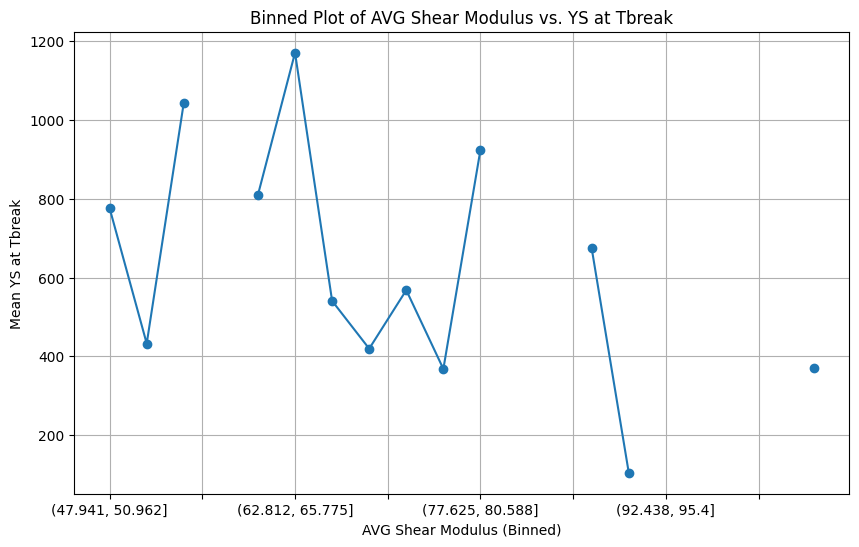

C:\Users\Sir\AppData\Local\Temp\ipykernel_19996\3795208505.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['binned_feature'] = pd.cut(filtered_df[feature], bins=20)  # You can adjust the number of bins
C:\Users\Sir\AppData\Local\Temp\ipykernel_19996\3795208505.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_means = filtered_df.groupby('binned_feature')['YS at Tbreak'].mean()


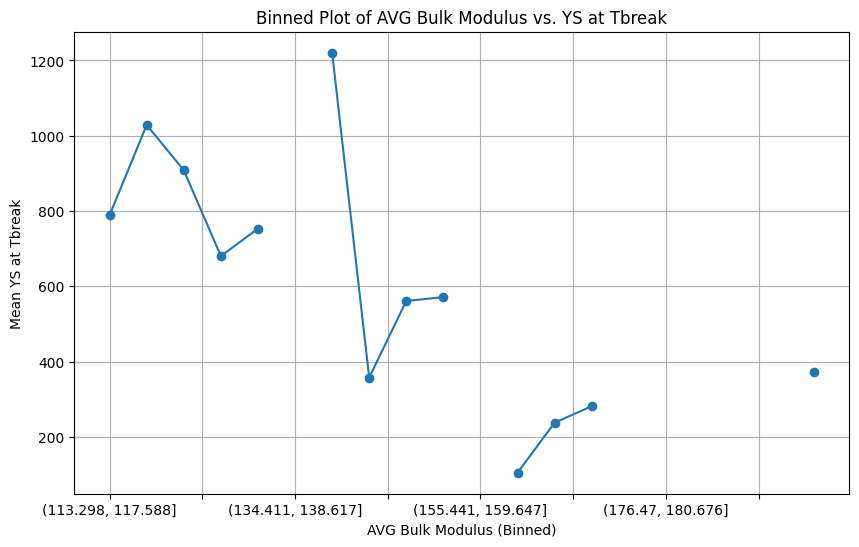

C:\Users\Sir\AppData\Local\Temp\ipykernel_19996\3795208505.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['binned_feature'] = pd.cut(filtered_df[feature], bins=20)  # You can adjust the number of bins
C:\Users\Sir\AppData\Local\Temp\ipykernel_19996\3795208505.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_means = filtered_df.groupby('binned_feature')['YS at Tbreak'].mean()


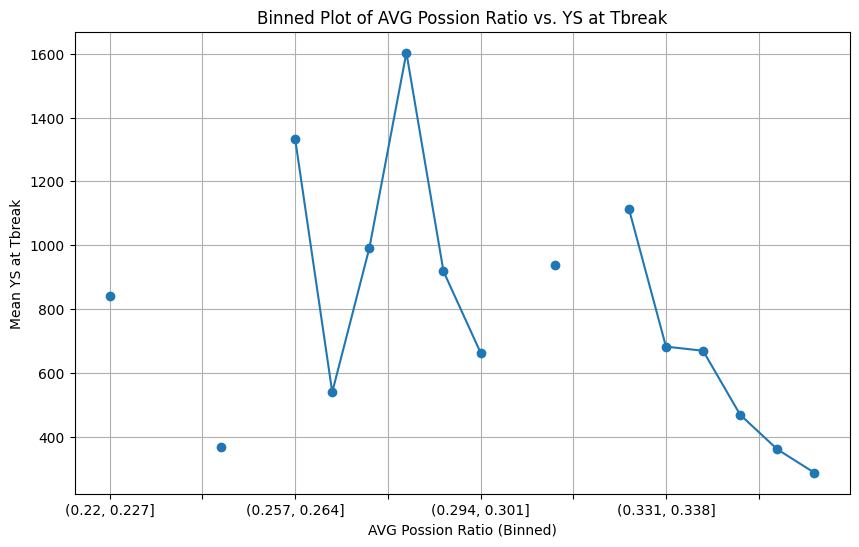

C:\Users\Sir\AppData\Local\Temp\ipykernel_19996\3795208505.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['binned_feature'] = pd.cut(filtered_df[feature], bins=20)  # You can adjust the number of bins
C:\Users\Sir\AppData\Local\Temp\ipykernel_19996\3795208505.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_means = filtered_df.groupby('binned_feature')['YS at Tbreak'].mean()


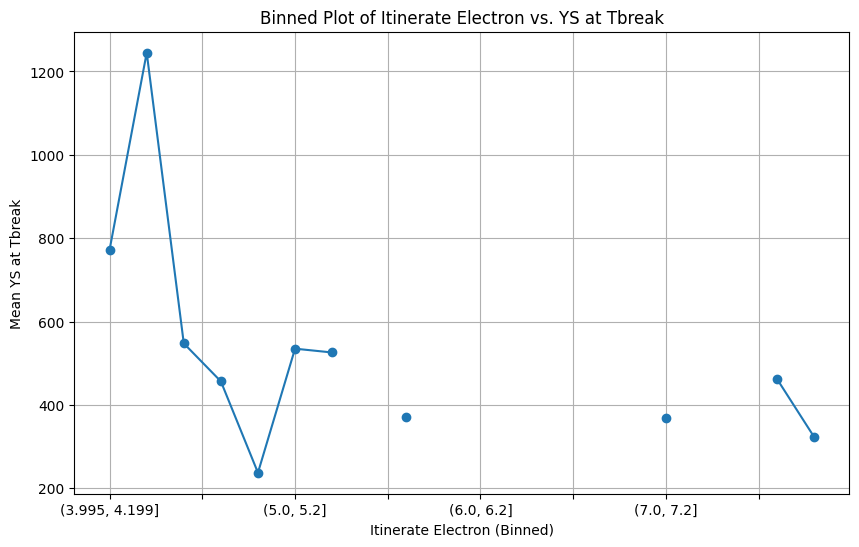

C:\Users\Sir\AppData\Local\Temp\ipykernel_19996\3795208505.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['binned_feature'] = pd.cut(filtered_df[feature], bins=20)  # You can adjust the number of bins
C:\Users\Sir\AppData\Local\Temp\ipykernel_19996\3795208505.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_means = filtered_df.groupby('binned_feature')['YS at Tbreak'].mean()


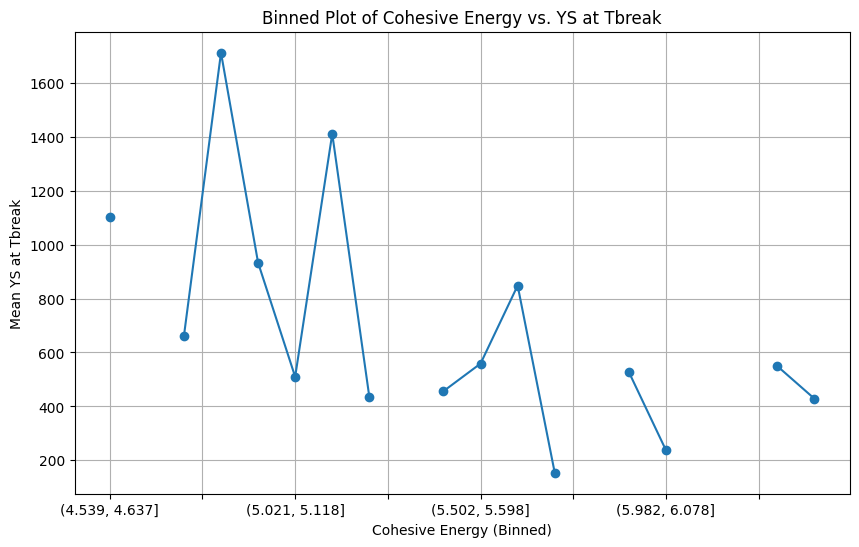

C:\Users\Sir\AppData\Local\Temp\ipykernel_19996\3795208505.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['binned_feature'] = pd.cut(filtered_df[feature], bins=20)  # You can adjust the number of bins
C:\Users\Sir\AppData\Local\Temp\ipykernel_19996\3795208505.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_means = filtered_df.groupby('binned_feature')['YS at Tbreak'].mean()


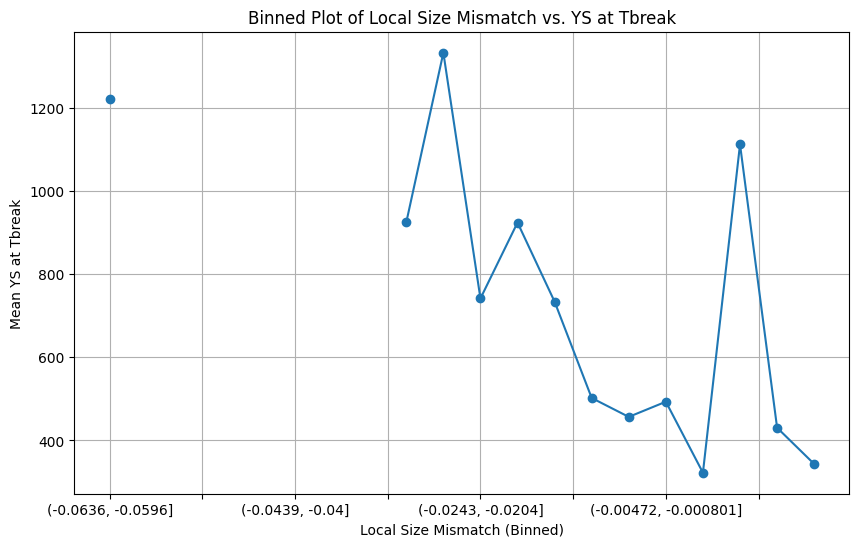

C:\Users\Sir\AppData\Local\Temp\ipykernel_19996\3795208505.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['binned_feature'] = pd.cut(filtered_df[feature], bins=20)  # You can adjust the number of bins
C:\Users\Sir\AppData\Local\Temp\ipykernel_19996\3795208505.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_means = filtered_df.groupby('binned_feature')['YS at Tbreak'].mean()


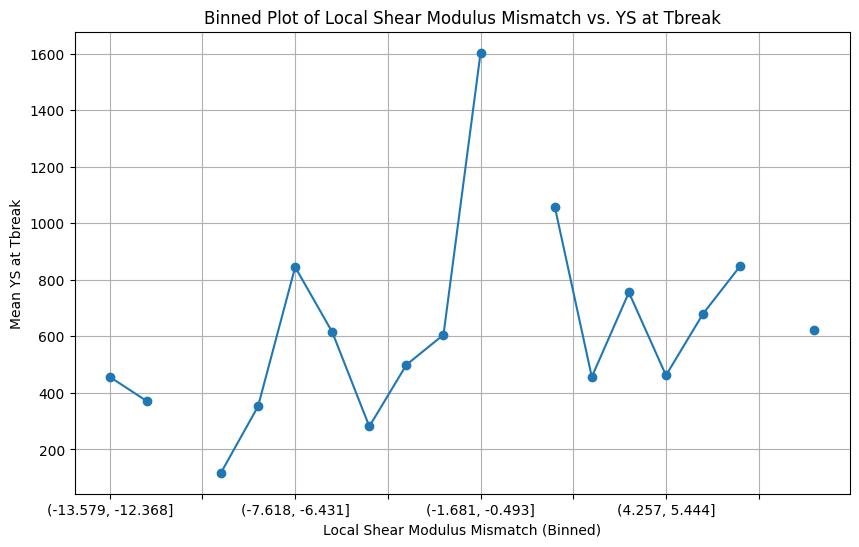

C:\Users\Sir\AppData\Local\Temp\ipykernel_19996\3795208505.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['binned_feature'] = pd.cut(filtered_df[feature], bins=20)  # You can adjust the number of bins
C:\Users\Sir\AppData\Local\Temp\ipykernel_19996\3795208505.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_means = filtered_df.groupby('binned_feature')['YS at Tbreak'].mean()


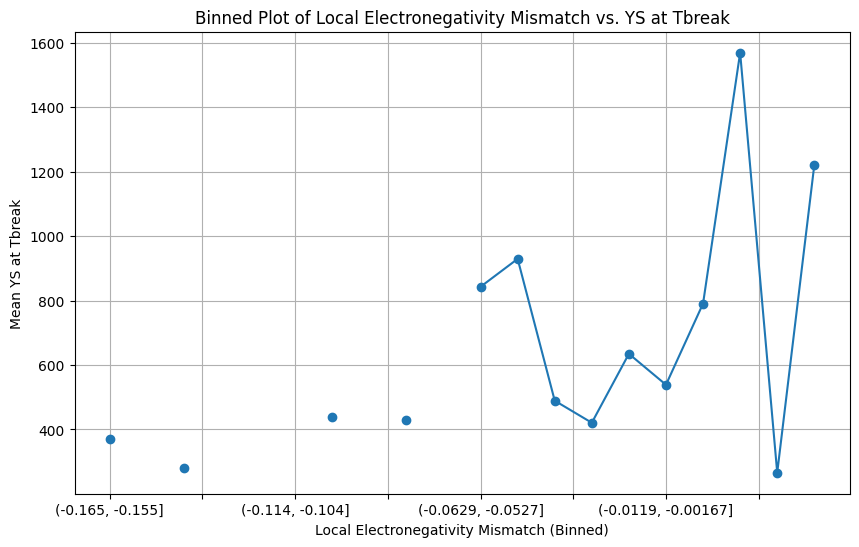

C:\Users\Sir\AppData\Local\Temp\ipykernel_19996\3795208505.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['binned_feature'] = pd.cut(filtered_df[feature], bins=20)  # You can adjust the number of bins
C:\Users\Sir\AppData\Local\Temp\ipykernel_19996\3795208505.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_means = filtered_df.groupby('binned_feature')['YS at Tbreak'].mean()


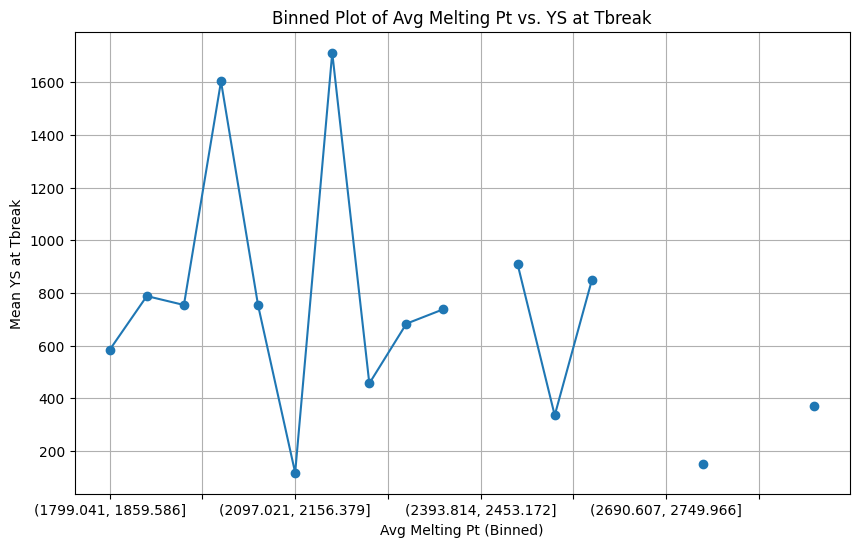

: 

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the dataset and filter as before
file_path = 'Tbreak_None_Removed_Updated.csv'
df = pd.read_csv(file_path)

# Filter the data with Tbreak > 1000K
filtered_df = df[df['Tbreak(K)'] > 1000]

# Define the features
features = [
    'VEC', 'ElectDiff', 'Atomic Size Diff', 'Mixing Enthalpy', 'Mixing Entropy',
    'AVG Shear Modulus', 'AVG Bulk Modulus', 'AVG Possion Ratio', 'Itinerate Electron',
    'Cohesive Energy', 'Local Size Mismatch', 'Local Shear Modulus Mismatch',
    'Local Electronegativity Mismatch', 'Avg Melting Pt'
]

# Plot the relationship for each feature
for feature in features:
    plt.figure(figsize=(10, 6))
    
    # Create bins and calculate the mean YS at Tbreak for each bin
    filtered_df['binned_feature'] = pd.cut(filtered_df[feature], bins=20)  # You can adjust the number of bins
    binned_means = filtered_df.groupby('binned_feature')['YS at Tbreak'].mean()
    
    # Plot the binned means
    binned_means.plot(kind='line', marker='o')
    
    plt.title(f'Binned Plot of {feature} vs. YS at Tbreak')
    plt.xlabel(f'{feature} (Binned)')
    plt.ylabel('Mean YS at Tbreak')
    plt.grid(True)
    plt.show()
